In [ ]:
import pandas as pd
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
#!pip install catboost
#from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
def fill_missing_values(data):
    
    '''
    Function to input missing values based on the column object type
    '''
    
    cols = list(data.columns)
    for col in cols:
        if data[col].dtype == 'int64' or data[col].dtype == 'float64':
        
            data[col] = data[col].fillna(data[col].mean())
        
        #elif data[col].dtype == 'O' or data[col].dtype == 'object':
        #    data[col] = data[col].fillna(data[col].mode()[0])
            
        else:
            data[col] = data[col].fillna(data[col].mode()[0])
            
    return data
 
def one_hot_encoding(traindata, *args):
    
    for ii in args:
        traindata = pd.get_dummies(traindata, prefix=[ii], columns=[ii])
        
    return traindata
 
def drop_columns(traindata, *args):
    
    #labels = np.array(traindata[target])
    
    columns = []
    for _ in args:
        columns.append(_)
        
    traindata = traindata.drop(columns, axis=1)
    #traindata = traindata.drop(target, axis=1)
    #testdata = testdata.drop(columns, axis=1)
        
    return traindata
 
def process(traindata):
    
    cols = list(traindata.columns)
    for _ in cols:
        traindata[_] = np.where(traindata[_] == np.inf, -999, traindata[_])
        traindata[_] = np.where(traindata[_] == np.nan, -999, traindata[_])
        traindata[_] = np.where(traindata[_] == -np.inf, -999, traindata[_])
        
    return traindata
 
def show_evaluation(pred, true):
  print(f'Default score: {score(true.values, pred)}')
  print(f'Accuracy is: {accuracy_score(true, pred)}')
  print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')
 
def freq_encode(data, cols):
    for i in cols:
        encoding = data.groupby(i).size()
        encoding = encoding/len(data)
        data[i + '_enc'] = data[i].map(encoding)
    return data
 
 
def mean_target(data, cols):
    kf = KFold(5)
    a = pd.DataFrame()
    for tr_ind, val_ind in kf.split(data):
        X_tr, X_val= data.iloc[tr_ind].copy(), data.iloc[val_ind].copy()
        for col in cols:
            means = X_val[col].map(X_tr.groupby(col).FORCE_2020_LITHOFACIES_LITHOLOGY.mean())
            X_val[col + '_mean_target'] = means + 0.0001
        a = pd.concat((a, X_val))
    #prior = FORCE_2020_LITHOFACIES_LITHOLOGY.mean()
    #a.fillna(prior, inplace=True)
    return a
 
def make_submission(prediction, filename):
 
  path = '/content/drive/My Drive/FORCE-Lithology-Prediction/'
 
  test = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/Test.csv', sep=';')
  #test_prediction = model.predict(testdata)
 
  #test_prediction
  category_to_lithology = {y:x for x,y in lithology_numbers.items()}
  test_prediction_for_submission = np.vectorize(category_to_lithology.get)(prediction)
  np.savetxt(path+filename+'.csv', test_prediction_for_submission, header='lithology', fmt='%i')
 
# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]
 
    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))
 
    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row
 
    return X_aug
 
# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad
 
# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows

In [ ]:
A = np.load('/content/drive/My Drive/FORCE-Lithology-Prediction/penalty_matrix.npy')
 
def score(y_true, y_pred):
    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]
 
def evaluate(model):
    feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
    plt.figure(figsize=(24,8))
    feat_imp.plot(kind='bar', title=f'Feature Importances {len(model.feature_importances_)}')
    plt.ylabel('Feature Importance Score')

In [ ]:
#importing miles
nr.seed(42)
train = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/train1.csv')
test = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/Test.csv', sep=';')
valida = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/valid4.csv')
valid2 = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/valid5.csv')
valid3 = pd.concat((valid1, valid2)).reset_index(drop=True)

In [ ]:
valida.WELL.value_counts()

30/3-3        21163
15/9-13       18270
7/1-1         16241
35/11-7       13005
34/12-1        9350
25/8-7         8999
31/4-10        8679
34/8-7 R       7084
25/11-19 S     6975
35/9-10 S      4313
Name: WELL, dtype: int64

In [ ]:
valid1 = valida.loc[valida.WELL=='30/3-3']
 
valid2 = valida.loc[valida.WELL=='15/9-13']
valid3 = valida.loc[valida.WELL=='7/1-1']
valid4 = valida.loc[valida.WELL=='35/11-7']
valid5 = valida.loc[valida.WELL=='34/12-1']
valid6 = valida.loc[valida.WELL=='25/8-7']
valid7 = valida.loc[valida.WELL=='31/4-10']
valid8 = valida.loc[valida.WELL=='34/8-7 R']
valid9 = valida.loc[valida.WELL=='25/11-19 S']
valid10 = valida.loc[valida.WELL=='35/9-10 S']
 
(valid1.isna().sum()/valid1.shape[0])*100

WELL                                   0.000000
DEPTH_MD                               0.000000
X_LOC                                  0.000000
Y_LOC                                  0.000000
Z_LOC                                  0.000000
GROUP                                  0.217360
FORMATION                             16.538298
CALI                                   0.368568
RSHA                                   0.278788
RMED                                   0.051978
RDEP                                   0.000000
RHOB                                   1.668005
GR                                     0.000000
SGR                                  100.000000
NPHI                                  81.472381
PEF                                   44.213958
DTC                                    2.565799
SP                                     0.000000
BS                                   100.000000
ROP                                  100.000000
DTS                                  100

In [ ]:
valid = pd.concat((valid1, valid2, valid3, valid4, valid5, valid6, valid7, valid8, valid9, valid10))
valid.shape

(114079, 29)

In [ ]:
ntrain = train.shape[0]
ntest = test.shape[0]
nvalid1 = valida.shape[0]
nvalid2 = valid2.shape[0]
nvalid3 = valid3.shape[0]
target = train.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
df = pd.concat((train, test, valid1, valid2, valid3)).reset_index(drop=True)

In [ ]:
train_well = train.WELL.values
train_depth = train.DEPTH_MD.values
 
valid1_well = valid1.WELL.values
valid1_depth = valid1.DEPTH_MD.values
 
valid2_well = valid2.WELL.values
valid2_depth = valid2.DEPTH_MD.values
 
valid3_well = valid3.WELL.values
valid3_depth = valid3.DEPTH_MD.values

In [ ]:
cluster_df = pd.DataFrame()
cluster_df['X_LOC'] = df.X_LOC
cluster_df['Y_LOC'] = df.Y_LOC
cluster_df['X_LOC'].fillna(cluster_df.X_LOC.mean(), inplace=True)
cluster_df['Y_LOC'].fillna(cluster_df.Y_LOC.mean(), inplace=True)
 
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300,
                n_init=10, random_state=40)
 
y_kmeans = kmeans.fit_predict(cluster_df)
df['LOC_cluster'] = y_kmeans#wcss = []

In [ ]:
df['LITHO'] = None
df.loc[df.GR < 70, 'LITHO'] = 'ss'
df.loc[df.GR > 70, 'LITHO'] = 'sh'
#df.loc[(df.GR >= 64) & (df.GR <= 98), 'LITHO'] = 'ssh'
df.LITHO.value_counts()

ss    809298
sh    703543
Name: LITHO, dtype: int64

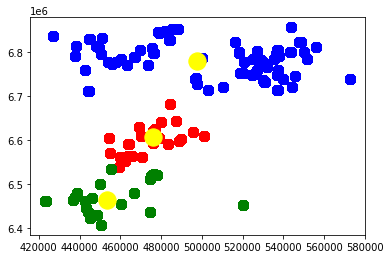

In [ ]:
plt.scatter(cluster_df.values[y_kmeans==0, 0], cluster_df.values[y_kmeans==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(cluster_df.values[y_kmeans==1, 0], cluster_df.values[y_kmeans==1, 1], s=100, c='blue', label ='Cluster 2')
plt.scatter(cluster_df.values[y_kmeans==2, 0], cluster_df.values[y_kmeans==2, 1], s=100, c='green', label ='Cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='yellow', label = 'Centroids')

In [ ]:
lithology = train['FORCE_2020_LITHOFACIES_LITHOLOGY']
valid1_lithology = valid['FORCE_2020_LITHOFACIES_LITHOLOGY']
valid2_lithology = valid2['FORCE_2020_LITHOFACIES_LITHOLOGY']
valid3_lithology = valid3['FORCE_2020_LITHOFACIES_LITHOLOGY']
 
lithology_numbers = {30000: 0,
                 65030: 1,
                 65000: 2,
                 80000: 3,
                 74000: 4,
                 70000: 5,
                 70032: 6,
                 88000: 7,
                 86000: 8,
                 99000: 9,
                 90000: 10,
                 93000: 11}
 
lithology = lithology.map(lithology_numbers)
valid1_lithology = valid1_lithology.map(lithology_numbers)
valid2_lithology = valid2_lithology.map(lithology_numbers)
valid3_lithology = valid3_lithology.map(lithology_numbers)

In [ ]:
print(df.shape)
cols = ['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 'RMIC', 'ROPA', 'RXO', 'MUDWEIGHT', 'DCAL', 'RSHA', 'SP']
df = drop_columns(df, *cols)
print(df.shape)

(1403077, 29)
(1403077, 20)


In [ ]:
df['GROUP_encoded'] = df['GROUP'].astype('category')
df['GROUP_encoded'] = df['GROUP_encoded'].cat.codes 
df['FORMATION_encoded'] = df['FORMATION'].astype('category')
df['FORMATION_encoded'] = df['FORMATION_encoded'].cat.codes
df['WELL_encoded'] = df['WELL'].astype('category')
df['WELL_encoded'] = df['WELL_encoded'].cat.codes
df.shape

(1403077, 23)

In [ ]:
df = df.drop(['WELL', 'GROUP', 'FORMATION'], axis=1)
df.shape
 
df = df.fillna(-999)
df = process(df)
data = df.copy()
 
train2 = data[:ntrain].copy()
target = train2.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
validation1_target = valid1.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
validation2_target = valid2.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
train2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
 
test2 = data[ntrain:(ntest+ntrain)].copy()
test2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
test2 = test2.reset_index(drop=True)
 
validation1 = data[(ntest+ntrain):(ntest+ntrain+nvalid1)].copy()
validation1.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
validation1 = validation1.reset_index(drop=True)
 
validation2 = data[(ntrain+ntest+nvalid1): (ntrain+ntest+nvalid1+nvalid2)].copy()
validation2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
validation2 = validation2.reset_index(drop=True)
 
 
validation3 = data[(ntrain+ntest+nvalid1+nvalid2):].copy()
validation3.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
validation3 = validation3.reset_index(drop=True)
 
print(train2.shape, test2.shape, validation1.shape, valid1.shape, validation2.shape, validation3.shape, valid2.shape)

(964965, 19) (136786, 19) (4313, 19) (4313, 29) (91467, 19) (205546, 19) (91467, 29)


In [ ]:
traindata = train2
testdata = test2
from sklearn.preprocessing import StandardScaler
 
scaler = StandardScaler().fit(traindata)
def scale_data(data):
  
  data = scaler.transform(data)
  #testdata = scaler.transform(testdata)
  data = pd.DataFrame(data, columns=testdata.columns)
 
  return data

In [ ]:
traindata, padded_rows = augment_features(traindata.values, train_well, train_depth)
validation1, padded_rows1 = augment_features(validation1.values, valid1_well, valid1_depth)
validation2, padded_rows2 = augment_features(validation2.values, valid2_well, valid2_depth)
validation3, padded_rows3 = augment_features(validation3.values, valid3_well, valid3_depth)
 
traindata.shape, validation1.shape, validation3.shape, validation2.shape

((964965, 76), (4313, 76), (205546, 76), (91467, 76))

In [ ]:
#func1_= Model(traindata, validation1, validation2, validation3, lithology, valid1_lithology, valid2_lithology, valid3_lithology)
#val1, open_test1, open_test11, model1 = func1_()

In [ ]:
#func2_= Model(traindata, validation1, validation2, validation3, lithology, valid1_lithology, valid2_lithology, valid3_lithology)
#val2, open_test2, open_test22, model2 = func2_()

In [ ]:
#func3_= Model(traindata, validation1, validation2, validation3, lithology, valid1_lithology, valid2_lithology, valid3_lithology)
#val3, open_test3, open_test33, model3 = func3_()

In [ ]:
#func4_= Model(traindata, validation1, validation2, validation3, lithology, valid1_lithology, valid2_lithology, valid3_lithology)
#val4, open_test4, open_test44, model4 = func4_()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-mlogloss:2.17155
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[99]	validation_0-mlogloss:0.322226
Default score: -1.8460758172965452
Accuracy is: 0.2763737537676791
F1 is: 0.3193424906377901
None
Default score: -0.55304645391234
Accuracy is: 0.7947128472563876
F1 is: 0.8192425195040695
None
-----------------------FOLD 1---------------------
[0]	validation_0-mlogloss:2.17143
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[99]	validation_0-mlogloss:0.31995
Default score: -1.8411778344539764
Accuracy is: 0.27475075353582196
F1 is: 0.33081456219900246
None
Default score: -0.5500973028523949
Accuracy is: 0.7965714410661768
F1 is: 0.8222828300434152
None
-----------------------FOLD 2---------------------
[0]	validation_0-mlogloss:2.1709
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[99]	validation_0-mlogloss:0.320177
Default score: -1.854567586366798
Accuracy is: 0.27127289589612796
F1 is: 0.322728841570

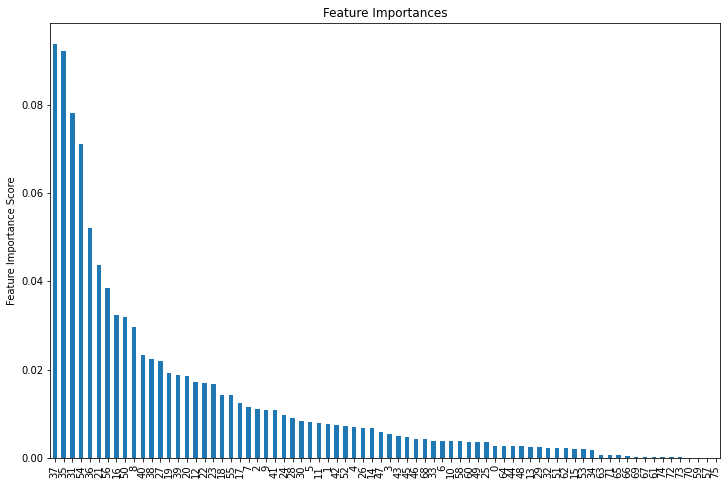

In [ ]:
func5_= Model(traindata, validation1, validation2, validation3, lithology, valid1_lithology, valid2_lithology, valid3_lithology)
val5, open_test5, open_test55, model5 = func5_()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-mlogloss:2.17257
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[99]	validation_0-mlogloss:0.316852
Default score: -0.45441160128903213
Accuracy is: 0.8372041337926436
F1 is: 0.8569887345967353
None
Default score: -0.5564329211628237
Accuracy is: 0.7931385089704484
F1 is: 0.8195455651040907
None
-----------------------FOLD 1---------------------
[0]	validation_0-mlogloss:2.17224
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[99]	validation_0-mlogloss:0.314005
Default score: -0.4049061006778531
Accuracy is: 0.852205800644516
F1 is: 0.8696151201592043
None
Default score: -0.5539333858112762
Accuracy is: 0.7939912755419988
F1 is: 0.8207207556507072
None
-----------------------FOLD 2---------------------
[0]	validation_0-mlogloss:2.17225
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[99]	validation_0-mlogloss:0.315843
Default score: -0.4633848205356151
Accuracy is: 0.833425936215135
F1 is: 0.85376180927

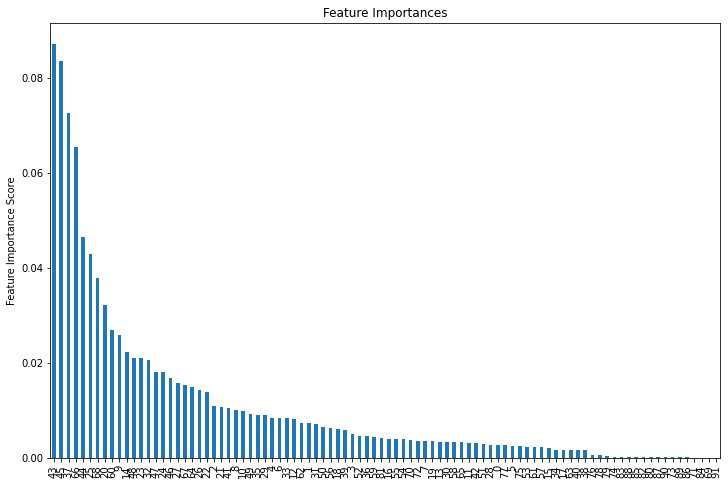

In [ ]:
func6_= Model(traindata, validation1, validation2, validation3, lithology, valid1_lithology, valid2_lithology, valid3_lithology)
val6, open_test6, open_test66, model6 = func6_()

In [ ]:
val1=val6

In [ ]:
func7_= Model(traindata, validation1, validation2, validation3, lithology, valid1_lithology, valid2_lithology, valid3_lithology)
val7, open_test7, open_test77, model7 = func7_()

In [ ]:
func8_= Model(traindata, validation1, validation2, validation3, lithology, valid1_lithology, valid2_lithology, valid3_lithology)
val8, open_test8, open_test88, model8 = func8_()

In [ ]:
func9_= Model(traindata, validation1, validation2, validation3, lithology, valid1_lithology, valid2_lithology, valid3_lithology)
val9, open_test9, open_test99, model9 = func9_()

In [ ]:
func10_= Model(traindata, validation1, validation2, validation3, lithology, valid1_lithology, valid2_lithology, valid3_lithology)
val10, open_test10, open_test110, model10 = func10_()

In [ ]:
valid1.FORCE_2020_LITHOFACIES_LITHOLOGY.value_counts()

65030    2684
30000     666
65000     536
70000     427
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, dtype: int64

In [ ]:
stack_p

,0
0,0
1,0
2,0
3,0
4,0
...,...
13000,0
13001,0
13002,0
13003,0


In [ ]:
stack = np.concatenate((val1, val2, val3, val4, val5))
stack.shape

(36050,)

In [ ]:
 stack_p = pd.concat((pd.DataFrame(val1), pd.DataFrame(val2), pd.DataFrame(val3), pd.DataFrame(val4)), axis=0)

In [ ]:
stack_p = pd.DataFrame(stack)
stack_p

,0
0,2
1,2
2,2
3,2
4,2
...,...
36045,0
36046,0
36047,0
36048,0


In [ ]:
#stack_df = pd.DataFrame(stack_p)
stack_p.to_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/stack_p1.csv', index=False)

In [ ]:
a = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/stack_p.csv')
b = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/stack_p1.csv')
#b1 = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/stack_df2.csv')
#.drop(['Unnamed: 0'], inplace=True, axis=1)
#.drop(['Unnamed: 0'], inplace=True, axis=1)
#.drop(['Unnamed: 0'], inplace=True, axis=1)
 
c = pd.concat((a, b))
c.shape

(114079, 1)

In [ ]:
#c.drop(['Unnamed: 0'], inplace=True, axis=1)
c = pd.DataFrame(val6)
c.shape

(4313, 1)

In [ ]:
c.columns

Index(['0'], dtype='object')

In [ ]:
stack_df = pd.DataFrame(val6)
stack_df.to_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/stack_df2.csv')

In [ ]:
show_evaluation(np.array(c['0']), valid1_lithology)

Default score: -0.6328180471427695
Accuracy is: 0.7624190254122143
F1 is: 0.7975943953931351


In [ ]:
valid1_lithology

0         2
1         2
2         2
3         2
4         2
         ..
114074    2
114075    2
114076    2
114077    2
114078    2
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, Length: 114079, dtype: int64

In [ ]:
stack = np.column_stack((pred1, pred2, pred3, pred4, pred5, pred6, pred7, pred8, pred9, pred10))
stack_p = np.column_stack((val1, val2, val3, val4, val5, val6, val7, val8, val9, val10))
stack_open = np.column_stack((open_test1, open_test2, open_test3, open_test4, open_test5, open_test6, open_test7, open_test8, open_test9, open_test10))
stack_open1 = np.column_stack((open_test11, open_test22, open_test33, open_test44, open_test55, open_test66, open_test77, open_test88, open_test99, open_test110))

In [ ]:
final_open_pred = pd.DataFrame(final_open_pred)
final_open_pred1 = pd.DataFrame(final_open_pred1)
final_open_pred11 = pd.DataFrame(final_open_pred11)
    
final_open_pred = np.array(pd.DataFrame(final_open_pred).idxmax(axis=1))
final_open_pred1 = np.array(pd.DataFrame(final_open_pred1).idxmax(axis=1))
final_open_pred11 = np.array(pd.DataFrame(final_open_pred11).idxmax(axis=1))

LOGISTIC REGRESSION META STACKER RESULT

In [ ]:
print(show_evaluation(final_open_pred, valid1_lithology))
print(show_evaluation(final_open_pred1, valid2_lithology))
print(show_evaluation(final_open_pred11, valid3_lithology))

Default score: -0.633995958940734
Accuracy is: 0.7617177569929611
F1 is: 0.7925249219163572
None
Default score: -0.5702425464921775
Accuracy is: 0.7877267211125324
F1 is: 0.8117928871333983
None
Default score: -0.6056259912622965
Accuracy is: 0.7732916232862717
F1 is: 0.8006195669948752
None


In [ ]:
print(show_evaluation(final_open_pred, valid1_lithology))
print(show_evaluation(final_open_pred1, valid2_lithology))
print(show_evaluation(final_open_pred11, valid3_lithology))

Default score: -0.6904940874306402
Accuracy is: 0.7402764750742906
F1 is: 0.7768162983540243
None
Default score: -0.590144533000973
Accuracy is: 0.7831895656356938
F1 is: 0.8097090499288114
None
Default score: -0.6458390092728635
Accuracy is: 0.759372597861306
F1 is: 0.7914893550723794
None


In [ ]:
stack_p.shape

(114079, 48)

In [ ]:
class Model():
    
    def __init__(self, train, validation1, validation2, validation3, train_label, valid_label1, valid_label2, valid_label3):
        
        
        self.train = train
        #self.test = test
        self.validation1 = validation1
        self.validation2 = validation2
        self.validation3 = validation3
        self.train_label = train_label
        self.valid_label1 = valid_label1
        self.valid_label2 = valid_label2
        self.valid_label3 = valid_label3
        
    def __call__(self, plot = True):
        return self.fit(plot)
    
    def fit(self, plot):
 
      #self.x_train, self.x_test, self.y_train, self.y_test = ms.train_test_split(self.train, 
                                                                                  # pd.DataFrame(np.array(self.train_label)), 
                                                                                   #test_size=0.2,
                                                                                   #random_state=212)
      #self.x_train = self.train.iloc[:700000]
      #self.x_test = self.train.iloc[700000:]
      #self.y_train = pd.DataFrame(self.train_label).iloc[:700000]
      #self.y_test = pd.DataFrame(self.train_label).iloc[700000:]
      
      def show_evaluation(pred, true):
        
        print(f'Default score: {score(true.values, pred)}')
        print(f'Accuracy is: {accuracy_score(true, pred)}')
        print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')
      split = 10
      kf = StratifiedKFold(n_splits=split, shuffle=True)
  
      #pred = np.zeros((len(self.test), 12))
      val1 = np.zeros((len(self.validation1), 12))
      val2 = np.zeros((len(self.validation2), 12))
      val3 = np.zeros((len(self.validation3), 12))
 
      #model = CatBoostClassifier(n_estimators=5000, random_state=2020, learning_rate=0.033,
                                 #use_best_model=True, max_depth=10, reg_lambda=1500,
                                 #eval_metric='MultiClass', task_type='GPU', verbose=100)
 
      model = XGBClassifier(n_estimators=100, max_depth=10, reg_lambda=1500, booster_type='gbtree',
                            objective='multi:softprob', learning_rate=0.1, random_state=0,
                            subsample=0.9, col_sample_bytree=0.9, tree_method='gpu_hist',
                            eval_metric='mlogloss', verbose=2020)
      
      #model = LGBMClassifier(n_estimators=50000, max_depth=10, reg_lambda=200,
                            #objective='multiclass', learning_rate=0.033,
                            #eval_metric='multi_logloss')
      
      #model = RandomForestClassifier(n_estimators=100, class_weight='balanced', verbose=2)
      i = 1
      for (train_index, test_index) in kf.split(pd.DataFrame(traindata), pd.DataFrame(lithology)):
        X_train,X_test = pd.DataFrame(traindata).iloc[train_index], pd.DataFrame(traindata).iloc[test_index]
        Y_train,Y_test = pd.DataFrame(lithology).iloc[train_index],pd.DataFrame(lithology).iloc[test_index]
    
        
        model.fit(X_train, Y_train, early_stopping_rounds=100, eval_set=[(X_test, Y_test)], verbose=100)
        #model.fit(X_train, Y_train)
        prediction1 = model.predict(pd.DataFrame(self.validation1))
        prediction = model.predict(pd.DataFrame(self.validation2))
        print(show_evaluation(prediction1, self.valid_label1))
        print(show_evaluation(prediction, self.valid_label2))
 
        print(f'-----------------------FOLD {i}---------------------')
        i+=1
 
        #pred += model.predict_proba(self.test)
        val1 += model.predict_proba(pd.DataFrame(self.validation1))
        val2 += model.predict_proba(pd.DataFrame(self.validation2))
        val3 += model.predict_proba(pd.DataFrame(self.validation3))
      
      #pred = pd.DataFrame(pred/split)
      val1 = pd.DataFrame(val1/split)
      val2 = pd.DataFrame(val2/split)
      val3 = pd.DataFrame(val3/split)
    
      #pred = np.array(pd.DataFrame(pred).idxmax(axis=1))
      val1 = np.array(pd.DataFrame(val1).idxmax(axis=1))
      val2 = np.array(pd.DataFrame(val2).idxmax(axis=1))
      val3 = np.array(pd.DataFrame(val3).idxmax(axis=1))
 
      print('---------------CROSS VALIDATION COMPLETE')
      print('----------------TEST EVALUATION------------------')
 
      print('----------Valid 1-------------')
      print(show_evaluation(val1, self.valid_label1))
      print('----------Valid 2-------------')
      print(show_evaluation(val2, self.valid_label2))
      print('----------Valid 3-------------')
      print(show_evaluation(val3, self.valid_label3))
                  
      if plot: self.plot_feat_imp(model)
      return val1, val2, val3, model
              
              
    def plot_feat_imp(self, model):
        feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
        plt.figure(figsize=(12,8))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-mlogloss:2.17102
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[99]	validation_0-mlogloss:0.317597
Default score: -1.2439839572192513
Accuracy is: 0.5127272727272727
F1 is: 0.571602728382017
None
Default score: -0.5664706943487815
Accuracy is: 0.788677883826954
F1 is: 0.8132841245547537
None
-----------------------FOLD 1---------------------
[0]	validation_0-mlogloss:2.17045
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[99]	validation_0-mlogloss:0.315399
Default score: -1.2578877005347593
Accuracy is: 0.5098395721925134
F1 is: 0.5750867495123634
None
Default score: -0.5660935091344419
Accuracy is: 0.7889293406365138
F1 is: 0.8139041291383725
None
-----------------------FOLD 2---------------------
[0]	validation_0-mlogloss:2.1711
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[99]	validation_0-mlogloss:0.32224
Default score: -1.255548128342246
Accuracy is: 0.512192513368984
F1 is: 0.5754673449919605

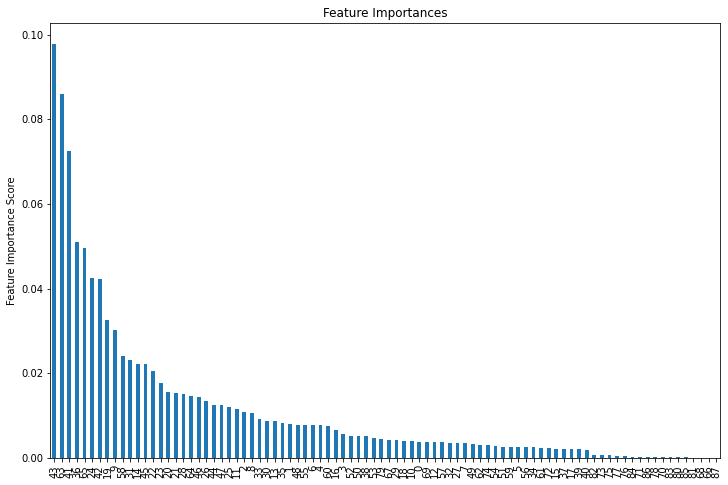

In [ ]:
func1_= Model(traindata, validation1, validation2, validation3, lithology, valid1_lithology, valid2_lithology, valid3_lithology)
val1, open_test1, open_test11, model1 = func1_()

In [ ]:
 print(show_evaluation(val2, valid1_lithology))
print(show_evaluation(open_test2, valid2_lithology))
print(show_evaluation(open_test22, valid3_lithology))

Default score: -0.6234298161800156
Accuracy is: 0.7660217919161283
F1 is: 0.7986957722089358
None
Default score: -0.5648157258902118
Accuracy is: 0.7891917303508369
F1 is: 0.8158804624594801
None
Default score: -0.597346822609051
Accuracy is: 0.7763323051774299
F1 is: 0.8058267796854165
None
